In [1]:
# setup
from mlwpy import *
%matplotlib inline

iris = datasets.load_iris()

# standard iris datset
tts = skms.train_test_split(iris.data, iris.target,
                            test_size=.33, random_state=21)

(iris_train_ftrs, iris_test_ftrs,
iris_train_tgt, iris_test_tgt) = tts

# one-class variation
useclass = 1
tts_1c = skms.train_test_split(iris.data, iris.target==useclass,
                               test_size=.33, random_state = 21)
(iris_1c_train_ftrs, iris_1c_test_ftrs,
 iris_1c_train_tgt, iris_1c_test_tgt) = tts_1c

# 8.1 Revisiting Classification

So far, we discussed two classifiers: Naive Bayes (NB) and *k*-Nearest Neighbors (*k*-NN).

There are a number of pieces to specify in classifiers:

1.  What rules do we give when separating classifiers? Are they straight lines? Are there more than one line? Do they have to be parallel to the edges of the paper? Can we use curves? How curvy can the lines be? Can we pick up the 'pencil' or must we make one and only one, continuous boundary before stopping?

2.  How do we evaluate the separation made? If *Xs* and *Os* show up in the same region, what is causing that?

Classification methods differ in two fundamental ways:

1. They have different constraints on how to draw their boundaries
2. They have different ways to evaluate the boundaries.  

The differences are side effects of the underlying mathematics of the methods.  

Once we have drawn *good* boundaries, we can ask simple questions to figure out the class of a new example: "Are we inside or outside the fenced area?" or "Which side of a very long fence are we on?" These questions can be simple, mathematical comparisons between a value computed from an example and a constant:

1. Which side of a fence are we on? Is some value greater than 0?
2. Which of the two possibilities is the answer? Is some value 0 or 1? Is some value -1 or 1?
3. Is one event the more likely of two? Is some value greater than $\frac{1}{2}$?
4. Am I the most likely of several alternative? Is some value the greatest in a set of values?

The first two questions are similar.  Often, the choice has to do with simplifying the underlying mathematics that we are setting aside for now.  The third question is a bit more genearl--not only can we say *which* outcome we prefer, but we can say *by how much* we prefer it.  If we don't have strict probabilities (instead we have generic scores), we might have a different threshold than one-half.  The fourth comes into play when we select between more than two classes. These questions are in their simplest forms.  Sometimes, we do a bit of additional processing before asking them.

In this chapter, we look at four different methods for classification: decision trees, support vector classifiers, logistic regression, and discriminant analysis.  In that order, these methods introduce increasing numbers of assumptions.  As we saw with Naive Bayes, the assumptions don't *prevent* us from applying a method: we are free to use *any* method with *any* data.  Often, we won't know what assumptions are met before we apply the method.  The better the alignment between the assumptions of a method and the patterns in the data, the better we expect a method to perfrom.  Since we don't know, we may try multiple emthods, cross-validate, and use the method with the best cross-validated results as our final tool.

# 8.2 Decision Trees

Trees are *prone to overfitting*  We reduce this tendency primarily by limiting the *depth* to which a tree can grow.

## 8.2.1 Tree-Building Algorithms

Tree-building methods result in a model that can be thought of as a *patchwork of constant predictors*.  The differences among DT revolve around:

1. How they break down the entire space of the data into smaller and smaller regions
2. When they stop the breakdown.

Here's how a decision tree classifier (DTC) breaks down the *iris* data when it only consideres the first two features (*sepal length* and *sepal width*).

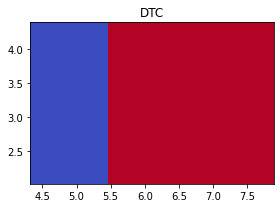

In [2]:
tree_classifiers = {'DTC' : tree.DecisionTreeClassifier(max_depth=1)}

fig, ax = plt.subplots(1,1,figsize=(4,3))
for name, mod in tree_classifiers.items():
    # plot_boundary only uses specified columns
    # [0,1] [sepal len/width] to predict and graph
    plot_boundary(ax, iris.data, iris.target, mod, [0,1])
    ax.set_title(name)
plt.tight_layout()

The red region (on the right) is *setosa*.  The blue (top left) and gray (lower center) are the two *v* classes.  Note that the boundaries are all made with lines that are parallel to the *x* and *y* axes.  Also, I'm sneaking in a `max_depth=3` argument to the DT constructor.  For now `max_depth` is simply the maximum number of questions I can ask of any example before I classify it.  Playing twenty questions is a bit like setting the `max_depth=20` constraint.

Breaking up the whole space creates a *partition*.  We predict the class of an examlpe based on the color of the region the example falls into.  Mathematically, we can write

$$ target = \Sigma_{R \in P} C_RI (example \in R)$$


The above equation is a very odd-looking dot product.  *R* is a region of our graph; *P* is the group of *all* regions.  Summing over all of the $R \in P$ means we add up some values over the whole graph.  $C_R$ and $I(example \in R)$ give us $C_R$ when an example is in *R* and give us zero everywhere else.  Together, these pieces look like $\Sigma C_R I$ which is exactly a pretty convoluted dot product.

Trees create blocky--think Legos or Tetris--regions of colored space from our features.  The partition--the shapes of the regions--is pretty constrained from one point of view.  It is made of overlaid rectangles where only the topmost rectangle counts.  Overlyaing cars as in Figure 8.4 gives us boundaries like those in Figure 8.5.  You can imagine neatly spreading out a few decks of cards on a rectangular table.  The cards are of different sizes and they must be horizontally and vertically aligned with the sides of the table.  The cards can overlap.  When cards of the same suit (clubs, hearts, diamonds, spades) are touching one another, they form a larger region of that suit.  To create those regions from points in space, we create simple yes/no answers by thresholding.  For example, we test a feature *Temp* against a value 55.  Choosing the values to split on is the trickiest aspect of implementing decision trees by hand. 

![](cards.jpg)

There are a number of major tree-building algorithms. ID3, C4.5, and C5.0 were made by Quinlan CART was developed independently.  In general, the tree-building algorithms use the following steps:

1. Evaluate the set of features and splits and pick a 'best' feature-and-split
2. Add a node to the tree that represents the feature-split
3. For each descendant, work with the matching data and either:
    1. If the targets are similar enough, return a predicted target
    2. If not, return to step 1 and repeat

Each step can be implemented and limited in different ways.  The DT algorithms control:
1. What splits and partitions are allowed
2. How feature-splits are evaluated
3. What makes targets in a group similar enough to form a leaf,
4. Other limits

The other limits commonly include an absolute limit on the depth of the tree and the minimum number of examples at a leaf to make a prediction, regardless of similarity.  These constraints help prevent overfitting.  AS with identifying labels, if we can continually break down the feature space until we have single examples in each bucket, we'll get perfect training accuracy--but we'll lose generalization.  Unconstrained trees have very little bias, but they do suffer from high variance.  We'll see examples shortly.

In [3]:
dtc = tree.DecisionTreeClassifier(max_depth=1)
skms.cross_val_score(dtc,
                     iris.data, iris.target,
                     cv=3, scoring='accuracy') # sorry

array([0.66, 0.66, 0.66])

Overall, they do quite well.

If we have a fit tree, we can view it graphically using one of two different methods.  The first needs an additional Python library, `pydotplus`, which you may not have installed on your computer.  The second requires an additional command-line program, `dot`, which you may have to install. `dot` is a program for drawing diagrams specified by text fieles, sort of like using HTML to specify how something looks on screen.  These outputs have a *Gini* value listed--we discuss that at the end of Chapter 13.  For now, just think of it as measuring how *pure* the class split is at that point.  If there is only one class represented, the *Gini* value is 0.0.

We'll use the simplified single-class iris problem here: it only results in a single split, even if we allow the tree the freedom to grow more deeply.

In [4]:
iris_1c_tree = (tree.DecisionTreeClassifier(max_depth=None)
                    .fit(iris_1c_train_ftrs, iris_1c_train_tgt))

In [5]:
iris_1c_tree

DecisionTreeClassifier()

In [6]:
# using an additional library:
# conda install pydotplus
# pip install pydotplus

![]

'[]' is not recognized as an internal or external command,
operable program or batch file.


In [7]:
import sys
!{sys.executable} -m pip install --upgrade pydotplus

You should consider upgrading via the 'c:\users\scott\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


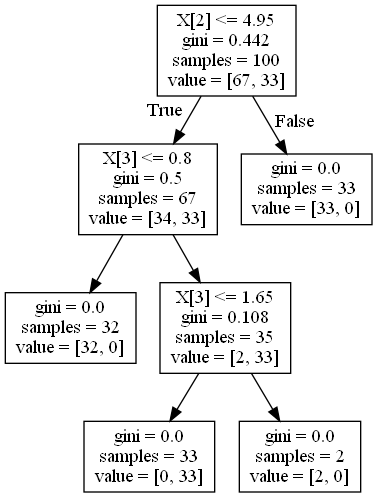

In [8]:
import pydotplus
import os
directory = 'outputs'

dot_data = tree.export_graphviz(iris_1c_tree, out_file=None)
graph = pydotplus.graph_from_dot_data(dot_data)

graph.write_png('outputs/iris_1c.png')
Image('outputs/iris_1c.png', width=500, height=500)


Invalid switch - "iris.dot".


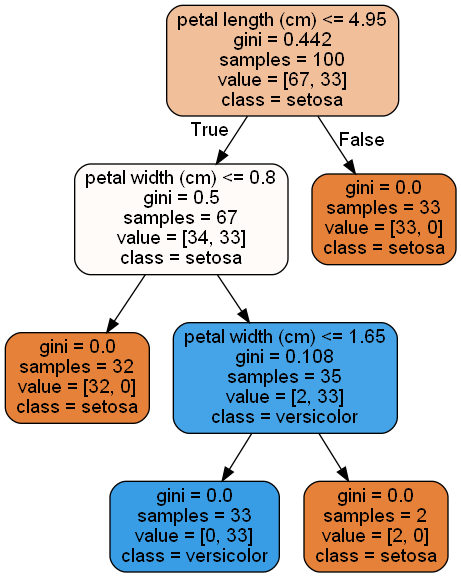

In [9]:
# no added library to produce .dot file
with open('outputs/iris.dot', 'w') as f:
    dot_data = tree.export_graphviz(iris_1c_tree, out_file=f,
                                    feature_names=iris.feature_names,
                                    class_names=iris.target_names,
                                    filled=True, rounded=True)
    
# the following '!' lines are "shell" commands
# uses the 'dot' program to convert dot -> png
!dot -Tpng outputs/iris.dot -o outputs/iris.png
!del /f outputs/iris.dot

Image('outputs/iris.png', width=500, height=500)

We can also get a feeling for what happens with increasing depth in a decision tree.  Let's take a look at the default tree from `DecisionTreeClassifier` and trees limited to depths 1, 2, and 3.  Remember, even at a `max_depth=2` we have three splits: one split for the root node and one split at each of the two children.  We expect to see these three splits as three cuts across our feature space.  The default setting, `max_depth=None` implies not constraining the depth at all, as if `max_depth =` $ \infty $.

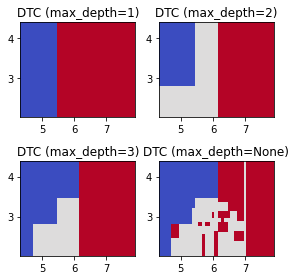

In [10]:
fig, axes = plt.subplots(2,2,figsize=(4,4))

depths = [1, 2, 3, None]
for depth, ax in zip(depths, axes.flat):
    dtc_model = tree.DecisionTreeClassifier(max_depth=depth)
    # plot_boundary only uses specified columns [0,1]
    # so we are only predicting with sepal length and width
    plot_boundary(ax, iris.data, iris.target, dtc_model, [0,1])
    ax.set_title('DTC (max_depth={})'.format(dtc_model.max_depth))
    
plt.tight_layout()

The top-right figure has three boundary lines--cut or divisions--we expect: one between gray and red, one horizontally between gray and blue, and one vertically between gray and blue.  The two gray blue edges com from two different splits.

### Bias and Variance in Decision Trees

IF we start with a wide open, no-depth-limit tree, we'll have a model that is very flexible and can capture *any* finite pattern that doesn't have coin-flipping randomness built into it.  If we use unconstrained trees, we will likely overfit.  When we try to generalize, we have poor test performance.  How can we *bias* our trees or place limits on them to prevent overfitting? We can take several steps.

1. We limit the depth of the trees. We allow fewer questions before categorizing.
2. We can require more examples at leaves.  This constraint forces us to group together examples that might be different, since we aren't allowed to separate them.  Effectively smoothing out some of our boundaries.
3. We can limit the number of features considered when asking questions of examples.  The constraint has the added benefit of speeding up our learning process.

# 8.3 Support Vector Classifiers (SVC)

A great oddity of logistic regression is that the underlying mathematics fail with perfectly separable data.  If drawing a line between the *Xs* and *Os* on paper is as simple as possible, the mathematics fall apart.  Let's look closer at the perfectly separable case.  What would *you* do with all the data falling neatly on either side of the tracks? (straight line).  Here are 3 possible lines:

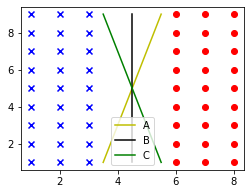

In [11]:
fig, ax = plt.subplots(1,1,figsize=(4,3))

# fancy way to get cross product of points
left = np.mgrid[1:4.0, 1:10].reshape(2, -1).T
right = np.mgrid[6:9.0, 1:10].reshape(2, -1).T

# data points
ax.scatter(left[:,0], left[:,1], c='b', marker='x')
ax.scatter(right[:,0], right[:,1], c='r', marker='o')

#separating lines
ax.plot([3.5, 5.5], [1,9], 'y', label='A')
ax.plot([4.5, 4.5], [1,9], 'k', label='B')
ax.plot([3.5, 5.5], [9,1], 'g', label='C')
ax.legend(loc='lower center');

The line *B* is called the *maximum margin separator* between the classes.

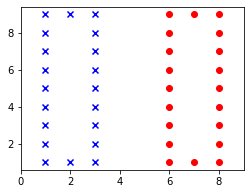

In [12]:
fig, ax = plt.subplots(1,1,figsize=(4,3))

# fancy way to get cross-product of points
left = np.mgrid[1:4:2, 1:10].reshape(2, -1).T
right = np.mgrid[6:9:2, 1:10].reshape(2, -1).T
ax.scatter(left[:,0], left[:,1], c='b', marker='x')
ax.scatter([2,2], [1,9], c='b', marker='x')
ax.scatter(right[:,0], right[:,1], c='r', marker='o')
ax.scatter([7,7], [1,9], c='r', marker='o')
ax.set_xlim(0,9);

We still have the outline, otherwise known as a hull, in the analogy of a hull of a ship, of our classes intact.  We can continue reducing the data we need to form the max-margin separating line.  Really, we don't need the *entire* border of both classes. Only the boundary points facing the opposing class really matter.  We can drop the non-facing points, as well.  We are left with two opposing lines of contestants facing off.

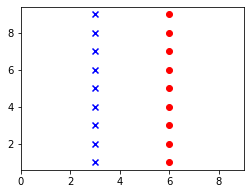

In [13]:
fig, ax = plt.subplots(1,1,figsize=(4,3))

left = np.mgrid[3:4, 1:10].reshape(2, -1).T
right = np.mgrid[6:7, 1:10].reshape(2, -1).T

ax.scatter(left[:,0], left[:,1], c='b', marker='x')
ax.scatter(right[:,0], right[:,1], c='r', marker='o')
ax.set_xlim(0,9);

In essence, we can throw out a lot of our data and just focus on the points that matter.  The points that matter are called the *support vectors*.  They are basically *supporting examples*.  The heart of a SVC is to

1. Find the *support vectors,* the border points 
2. Do the mathematics necessary to figure out the *maximum margin separator* between poitns.

SVC try to balance off two competing concerns: getting the biggest margin between the example classes and minimizing the number of training errors.

The example above had no *hard* training examples, everything fell on its own side of the tracks.  

Two additional notes.  

1. A big margin is good because under certain assumptions it leads to good generalization and good test set error.
2. There are really two things that drive the need for more support vectors: additional complexity in the boundary between the classes and examples that don't play nicely with the proposed boundaries.

We are talking about Support Vector Classifiers (SVCs).  Their elder sibling is Support Vector Machines (SVMs).  SVCs have some nice mathematical and practical properties:

1. They are sparse, which means they focus on the hard training examples near the margin.  They adapt by storing more examples if necessay.  Contrast this with *k*-NN, which *always* needs to store *all* of the training examples to make predictions.
2. The form of the SVC classification boundary is simple: it's a line.  The boundary can be made more complicated in a convenient way that we'll discuss when we talk about SVMs.
3. SVCs genearlize well to novel test data because they try to leave as much cushioning between classes as possible--that's the maximum-margin principle coming to the rescue.
4. The underlying optimization problem--finding the best line--leads to *the* best line given our constraints.  We don't get a suboptimal line.

### 8.3.1 Performing SVC

A few practical details that go along with using SVC:

* SVCs aren't naturally suited to multiclass classification.  They are typically wrapped up in either one-versus-one (OvO) or one-versus-rest (OvR) systems.  
    * You do not need to add this capability to SVMs.  It is done behind the scenes for you.  As of `scikit-learn` version `0.19`, the methods are all standardized on using OvR.
    
    * There are four ways (actually more) that we can get a SVC in `sklearn`: 
        * (1) using `LinearSVC`
        * (2) using `SVC` with a *linear kernel*
        * (3) using `SVC` with a *polynomial kernel* of degree 1 (in line in disguise),
        * (4) using a `NuSVC` with a linear kernel.
        
    * The four methods do not necessarily lead to the *exact* same results due to mathematical, implementation, and default-argument differences.
        * Reconciling the differences in painful
        * Kernels are a coding detail for now.
        
#### 8.3.1.1 Just the Facts: Running SVCs

Here, we focus on just two of the SVC options: `SVC` and `NuSVC` 

We get into the `nu` parameter in a moment, but we selected its value of `.9` to get a result close to that of the `SVC`.


In [14]:
sv_classifiers = {"SVC(Linear)"   : svm.SVC(kernel='linear'),
                  "NuSVC(Linear)" : svm.NuSVC(kernel='linear', nu=.9)}

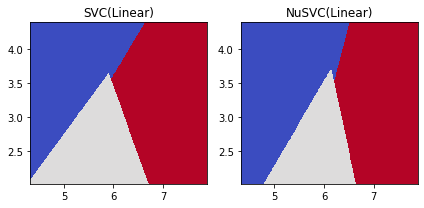

In [15]:
fig, axes = plt.subplots(1,2,figsize=(6,3))
for (name, mod), ax in zip(sv_classifiers.items(), axes.flat):
    plot_boundary(ax, iris.data, iris.target, mod, [0,1])
    ax.set_title(name)
plt.tight_layout()    

To get a quick glance, `SVC` and `NuSVC` are pretty similar, but the precise angles of the region boundaries are not identical. 

#### 8.3.1.2 Parameters for SVCs

`SVC` relies on one primary parameter, `C` to control its bias-variance tradeoff. `C` can be difficult to interpret directly. `NuSVC` solves the same task as `SVC` , but it relies on different mathematics.  We bother with it because the primary parameter for `NuSVC`, *v*--pronounced *new* and written in English as *nu*--has a simple meaning: *at least v%* of the data will be kept as a support vector.  

It also has a consequence on errors, but errors on a special type: *margin errors*.  Margin errors are points that:

1. Either on the wrong side of the separator (a classification error)
2. on the correct side of the separator (correctly classified) *but* within the margin.   

So, the effects of *v* is that we tolerate *at most v%* margin errors in our training data.  Under certain circumstances, margin errors increase to *v* and support vectors decrease to *v*.  

Values of *v* are in the range [0, 1] which we interpret as a percent from 0% ot 100%.  While harder to interpret, `SVC` has better runtime characteristics than `NuSVC`.




In [16]:
def do_linear_svc_separators(svc_maker, pname, params, ax):
    'create svc(params) and draw separation boundary'
    xys = (np.linspace(2,8,100),
           np.linspace(2,8,100))
    
    for p in params:
        
        kwargs = {pname:p, 'kernel':'linear'}
        svc = svc_maker(**kwargs).fit(ftrs, tgt)
        # plot_separator is in mlwpy.py
        plot_separator(svc, *xys,'{}={:g}'.format(pname, p), ax=ax)


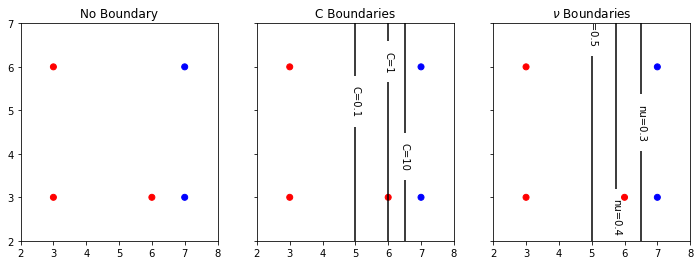

In [17]:
ftrs = np.array([[3,3],
                 [3,6],
                 [7,3],
                 [7,6], 
                 [6,3]])
tgt = np.array([0,0,1,1,0])
colors = np.array(['r', 'b'])

Cs = [.1, 1.0, 10]
nus = [.3, .4, .5]

fig, axes = plt.subplots(1,3,figsize=(12,4),
                         sharex=True, sharey=True)

for ax in axes:
    ax.scatter(ftrs[:,0], ftrs[:,1], c=colors[tgt])
    
ax.set_xlim(2,8); ax.set_ylim(2,7)

do_linear_svc_separators(svm.SVC, "C", Cs, axes[1])
do_linear_svc_separators(svm.NuSVC, "nu", nus, axes[2])

axes[0].set_title("No Boundary")
axes[1].set_title("C Boundaries")
axes[2].set_title(r"$\nu$ Boundaries");

# the two right most points are blue
# the remaining three points are red

There are two take-home message here:

1. A bigger *v* and a smaller *C* have approximately the same effect.  The *scales* of *v* and *C* are quite different however.
    1. We're using orders of magnitude in *C* and we're using linear, one-tenth, steps in *v*.
    
2. Bigger *v* and smaller *C* can get us a SVC that to some extent *ignores* misclassificaiton.



## 8.3.2 Bias and Variance in SVCs

One last set of comments is appropriate here.  Let's look at how our parameters *v* in `NuSVC` and *C* in `SVC`--relate to bias and variance.  We start by creating some data: 

In [18]:
ftrs

array([[3, 3],
       [3, 6],
       [7, 3],
       [7, 6],
       [6, 3]])

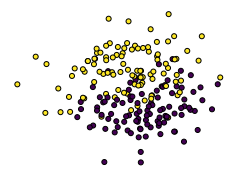

In [19]:
ftrs, tgt = datasets.make_blobs(centers=2,
                                n_features=3,
                                n_samples=200,
                                center_box = [-2, 2],
                                random_state=1099)

# note: using three features, but graphing only two dimensions
fig, ax = plt.subplots(1,1,figsize=(4,3))
ax.scatter(ftrs[:, 0], ftrs[:, 1],
           marker='o', c=tgt, s=25, edgecolor='k')
ax.axis('off');

#generally the yellow class is on top
# and the purple class is on bottom

Now, well look at the effect of *v*:

In [20]:
tt

NameError: name 'tt' is not defined

```python
nus = np.linspace(0.05, 1.0, 10)

tt = skms.validation_curve(svm.NuSVC(kernel='linear'),
                           ftrs, tgt,
                           param_name='nu',
                           param_range=nus,
                           cv=5)
fig,ax = plt.subplots(1, 1,figsize=(4,3))
ax = sns.lineplot(np.array(tt).transpose(),
                  time=nus,
                  condition=['Train', 'Test'],
                  interpolate=False)

ax.set_title('5-fold CV Performance for NuSVC')
ax.set_xlabel('\n'.join([r'$\n$ for $\nu$-SVC']))
ax.set_ylim(.3, 1.01)
ax.legend(loc='lower center');
```

![](svc.jpg)

We see that a very large *v* is awful for training and testing.  WE can't capture enough of the pattern to do anything--we are too biased.  On the other hand, decreasing *v8 lets us catpure *some* pattern--but when we go to test, we simply don't do very well.  We aren't generalizing because we have overfit the training data.  Broadly speaking a small *v* is equivalent to a large *C*, although the scales differ.


```python
cs = [0.0001, 0.001, 0.01, .1, 1.0, 10, 100, 1000]
tt = skms.validation_curve(svm.SVC(kernel='linear'),
                           ftrs, tgt,
                           param_name='C',
                           param_range=cs,
                           cv=5)
fig,ax =plt.subpltos(1,1,figsize=(4,3))
ax = sns.tsplot(np.array(tt).transpose(),
                time=cs,
                condition=['Train', 'Test'],
                interpolate=False)

ax.set_title('5-fold CV Performance for SVC')
ax.set_xlabel('\n'.join([r'C for SVC']))
ax.set_ylim(.8, 1.01)
ax.set_xlim(.00001, 10001)
ax.set_xscale('log')
```

![](SVC-2.jpg)

On the left, at small *C* values, both our training and testing performance is relatively poor.  On the right, at large *C*, our training performance is better than our test.  High values of *C* lead to overfitting and low values of *C* lead to underfitting.  While *C* is harder to interpret than *v*, it trades off between the complexity of our model and the errors we make.  A bigger *C* means that we care more about errors compared to complexity.  With a really big *C*, even the smallest errors matter a lot.  So we build a model with a lot of complexity to cover those errors.  We'll make our view of this tradeoff more concrete in Chapter 15.

# 8.4 Logistic Regression

Logistic regression is a linear classification technique.  It is bot a regression rechnique and a classification technique. Logistic regression is a *classification* method that uses *regression* as an internal component.  Logistic regression works in two stages: 

1. It computes something closely related to the probabilities of being in each target class
2. It labels an example with the highest-probability class.

The first step is a regression from the predictors to the not-quite-probabilities.  
Next, we take a threshold against the not-quite-probabilities, or taking a maximum among several values, gives us a class.

The *log-odds* are the not-quite probabilities mentioned above, which form a tight relationship between linear regression and logistic regresison.

# 8.4.1 Betting Odds

We deisgn a game where are probability of *winning* is 10%.  Of ten total attempts, we expect one win and nine losses.  If we create the ratio of the two numbers, we get $ \frac{1}{9} \approx .1111 $.  These are the *odds* of winning.  They can also be written as 1 : 9.  This, however, is *not* the *odds-ratio*: that is a *different* concept.

For a given set of odds what is a *fair bet* for the odds? 

What amount of money do the participants wager so that in the long run, the game is fair.  

We have 9 spades and 1 heart.  We shuffle and pick a card.  If it is a heart, we win, if not, the dealer wins.  How much should I and the dealer be willing to risk on the simple game if we want to have a fair outcome?

What is the break-even point where we both expect to win the same amount of money?

To figure out the break-even point, let's start with concrete numbers.  Here's an example where we both wager $10.

$$ MyWinnings = (.1 \times 10) + (.9 \times -10) = 1 - 9 = -8 $$
$$ DealerWinnings = (.9 \times 10) + (.1 \times -10) = 9 - 1 = 8 $$

To compute this, we took the two possible outcomes, a win and a loss and combined

1. the two probabilities of those outcomes (.1, .9)
2. the two monetary results of those outcomes (10, -10)

with a dot product.  Writing this out mathematically gives us $\Sigma_{outcome}P_{outcome}\nu_{outcome}$

where p and v are the probabilities and dollar-values for each outcome.  

This particular dot product is called the *expected value* of winnings when someone plays the game.

Notice that since no money disappears, we have a true *zero-sum game* and our total winnings must balance out to zero.  Therefore, if we both risk an equal amount of money, we will lose money.

To balance things out, I should stake *less money* than the dealer because I have lower odds of winning.  What is the break-even point for a bet?

We could perform some algebra to calculate the answer, but let's do it experimentally with code.  We'll look at pairs of bets from $1 to $11 in setps of $2 and compute Mark's winnings.  We make use of two helper functions.

In [ ]:
def simple_argmax(arr):
    'helper to convert np.argmax into something usable '
    return np.array(np.unravel_index(np.argmax(arr),
                                     arr.shape))

def df_names(df, idxs):
    ' helper to convert number of index/column labels'
    r,c = idxs
    return df.index[r], df.columns[c]

Now, we create a table of the outcomes for several combinations of betting:

In [ ]:
base_bets = np.arange(1,12,2)
mark_bet, andy_bet = np.meshgrid(base_bets, base_bets)

mark_winnings = .1 * andy_bet + .9 * -mark_bet

df = pd.DataFrame(mark_winnings,
                  index = base_bets,
                  columns=base_bets)

df.index.name = 'Andy Bet'
df.columns.name = 'Mark Bet'

print('Best Betting Scenario (for Mark) for These Values:')
print('(Andy, Mark):', df_names(df, simple_argmax(mark_winnings)))

display(df)

If my overall expected winnings are zero, so are the dealers.  The best outcome for me is in the lower-left corner of the table.  It occurs when I wager \\$1 and Andy wagers \\$11.  That's my lowest bet and Andy's highest bet.  Now, if Andy is willing to play a game where I bet \\$1 and he bets \\$99, things look different for me.  I win 10% of the time, so I'm looking at $.1 \times 99 + .9 \times -1 = 9$ If we played with these bets many times, I'd start coming out ahead.

If two players had an equal probability of winning, the probabilities would be .5 each.  These correspond to an odds of 1 : 1 which we write as odds = 1.  These values are the tipping point between winning and losing.  Higher values 0.75, odds 3 : 1) make one event or winner *more* likely and the other *less* likely.

## 8.4.2 Probabilities, Odds, and Log-Odds

Now we understand odds.. What we care about is *log-odds*.  We start by creating a table of some probability values with corresponding odds and log-odds.  The log-odds are the mathematical logarithm applied to the odds values: log(odds).

In [ ]:
tail_probs = [0.0, .001, .01, .05, .10, .25, 1.0/3.0]

lwr_probs = np.array(tail_probs)
upr_probs = 1-lwr_probs[::-1]
cent_prob = np.array([.5])

probs = np.concatenate([lwr_probs, cent_prob, upr_probs])
print(f'lwr_probs: {lwr_probs}')
print(f'upr_probs: {upr_probs}')
print(f'probs: {probs}')

# much better than geterr/seterr/seterr
with np.errstate(divide='ignore'):
    odds  = probs / (1-probs)
    log_odds = np.log(odds)
    
index=['{:4.1f}%'.format(p) for p in np.round(probs,3)*100]

polo_dict = co.OrderedDict([('Prob(E)', probs),
                            ('Odds(E:not E)', odds),
                            ('Log-Odds', log_odds)])
polo_df = pd.DataFrame(polo_dict, index=index)
polo_df.index.name='Pct(%)'
polo_df

We can change this to a graphical view, let's look at the relatoinship between probabilities and odds (expressed as fractions):

In [ ]:
def helper(ax,x,y,x_name,y_name):
    ax.plot(x,y, 'r--o')
    ax.set_xlabel(x_name)
    ax.set_ylabel(y_name)
    
# note we trim the values above 90% [index -5] b/c
# the scale of the plots gets too compressed
# (huh, log-scale takes care of that! funnny ....)

fig, (ax0, ax1) = plt.subplots(1,2, figsize=(9,3))
helper(ax0, probs[:-5], odds[:-5], 'probability', 'odds')
helper(ax1, odds[:-5], probs[:-5], 'odds', 'probability')

and the relationship between probabilities and log-odds:

In [ ]:
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(9,3))
helper(ax0, probs, log_odds, 'probability', 'log-odds')
helper(ax1, log_odds, probs, 'log-odds', 'probability')

Looking at the first and last rows of the table, you see the extreme values for each of the probabilities, the odds, and log-odds.  The min and max probabilities correspond with events that are either impossibilities or guarantees.  Such things rarely happen.

Ranges of values:

In [ ]:
pd.DataFrame([polo_df.min(axis=0),
              polo_df.max(axis=0)], index=['min', 'max']).T

### 8.4.3. Just Do It: Logistic Regression Edition

`sklearn` has several methods for performing logistic regression.  We call them through `LogisticRegression` and `SGDClassifier`.  

In Section 4.4, we talked about four ways of picking a 'preferred' set of parameters.  The methods used by `sklearn` for logistic regressoin are smart step methods: from a starting point, make some adjustments, and repeat as necessary until the answer is *good enough*.  `SGD` stands for *Stochastic Gradient Descent* and it is one way of performing smart steps.  

It makes adjustments by looking at the errors in the current guess and using those to lower the error of the next guess.  We tell `SGDClassifier` to use a *log-loss* model of the errors which gives us logistic-regression-like behavior.  Other losses lead to other classification methods.  `SGDClassifier` can handle very large problems, but it takes multiple iterations to do so and, because of its internal use of randomness, every run may result in a different answer.  With enough data and small  enough error tolerenace, `SGDClassifier` should reach, or convert to, similar answers on different run.

The other logistic regression method we'll use is `LogisticRegression` with `method='saga'`.  `Saga` allows us to use a full multiclass model instead of wrapping a binary classification with a one-versus-rest.

In [ ]:
# Both options come with 'regularization' turned ON
# we'll ignore that for now, but see Chapter 9 for more details
LogReg = linear_model.LogisticRegression
SGD = linear_model.SGDClassifier
logreg_classifiers = {'LogReg(saga)': LogReg(solver='saga',
                                             multi_class='multinomial',
                                             max_iter=1000),
                      'LogReg(SGD)' : SGD(loss='log', max_iter=1000)}

fig, axes = plt.subplots(1,2,figsize=(12,4))
axes = axes.flat

for (name, mod), ax in zip(logreg_classifiers.items(), axes):
    plot_boundary(ax, iris.data, iris.target, mod, [0,1])
    ax.set_title(name)
    
plt.tight_layout()

## 8.4.4 A logistic Regression: A Space Oddity

If all the data falls into two nice clusters, there are an infinite number of lines we can draw betwen the clusters.  Logistic regression has no built-in answer to pick one of the infinite alternatives.  Trying to solve a perfectly separable classification problem with LR may lead to problematic answers.  Fortunately:

1. Those problems are more serious for statisticians that they are for us using logistic regression as a black-box prediction method
2. For practical purposes in interesting problems, we never have perfectly separable data.

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(4, 1))

x = np.array([1,2,5,10]).reshape(-1, 1)
y = ['red', 'blue', 'red', 'blue']
ax.scatter(x,np.zeros_like(x), c=y)

This is a typical scenario: the two classes are intertwined.  We use a non-`sklearn` method to perform logistic regression.

The method is a bit old-school, but will expose our issue clearly.

In [ ]:
x

In [ ]:
import statsmodels.api as sm

#x = np.c_[x, np.ones_like(x)] # +1 trick
tgt = (np.array(y) == 'red')

# sm.Logit is statsmodel name for logistic regression
(sm.Logit(tgt, x, method='newton')
   .fit()
   .predict(x))  # training predictions

Everything so far looks well behaved.  Look what happens with a seemingly minor change to the data.

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(4,1))

x = np.array([1,4,6,10]).reshape(-1, 1)
y = ['red', 'red', 'blue', 'blue']
ax.scatter(x, np.zeros_like(x), c=y)

In [ ]:
tgt = (np.array(y) == 'red')

try:
    sm.Logit(tgt, x, method='newton').fit().predict(x) # in-sample preds
except Exception as e:
    print(e)

`Logit` is supposed to refuse to solve the problem.  It's supposed to warn there was perfect separation between the classes and there are no results to use.  The problem is that there is an infinite number of lines that we could draw and our old-school logistic regression doesn't have a built-in way to pick between them.  In turn, some methods don't do well with taht uncertainty and can give bad answers.  Hence, `Logit` is supposed to output with a *fail*.

# 8.5 Discriminant Analysis

*Discrimant analysis* (DA) is used to tell subtle difference that allow us to classify things.

DA methods are interesting for at least three reasons:

1. They have a wonderfully clear mathematic connection with Naive Bayes on continuous features (Gaussian Naive Bayes, GNB)
2. Like GNB, discrimant analysis methods model the features and the target *together*.
3. DA methods arise from particularly simple--or perhaps mathematically convenient--assumptions about the data.  The different DA methods make slightly different assumptions.

Each DA metho works by making *assumptions* about the *true* nature of the data.  *The assumptions could be wrong*.

Here are the sorts of assumptions these methods make:

1. Features one and two talk to each other.  They care what class has to say.
2. Features one and two talk to each other.  They don't care what Class has to say.
3. Feature one doesn't talk to Feature two directly.  Anything Feature one knows comes from talking to Class.  
4. Feature one doesn't talk to feature two, *nor* does it care what class has to say.

The assumptions lead to different models.  

## 8.5.1 Covariance

Covariance describes one way in which the features are related--or not-- to each other.  If we are looking at physiological data on medical patients, our models might make good use of the fact that height and weight have a strong relationship.

The covariance encoded the differnt ways features may metaphorically communicate with each other.

Here, we are talking about the use of covariance as an internal widget of a learning machine.  Different constraints on covariance lead to different learning machines.  

We start by talking about *variance*.  Remember, variance is the *sum of squared errors* of a model that predicts the mean value.

$$ Var(X) = \frac{1}{n}\Sigma_{x \in X} (x - \bar{X})^2$$


You might recognize a dot product in the formula for variance `var_X = dot(x-mean_X, x-mean_X) / n`  If we write the variance out as code for the sum of squared errors from the mean, it might look more familiar.

In [ ]:
X = np.array([1,3,5,10,20])
n = len(X)

mean_X = sum(X) / n
errors = X - mean_X
var_X = np.dot(errors, errors) / n

fmt = 'long way: {}\nbuilt in: {}\n close: {}'
print(fmt.format(var_X,
                 np.var(X),
                 np.allclose(var_X, np.var(X)))) # phew

#### 8.5.1.1 The Classic Approach

If we have two variables, we don't get quite the same easy verbal phrasing of comparing with a mean model.  Still, if I said that we take *two* models that predict the means for the two variables and *multiply* them together, you might come up with something like:



$$ Cov(X, Y) = \frac{1}{n} \Sigma_{x \in X \\ y \in Y} (x - \bar{X})(y-\bar{Y}) $$

In code this looks like the following:

In [ ]:
X = np.array([1,3,5,10,20])
Y = np.array([2,4,1,-2,12])

mean_X = sum(X) / n
mean_Y = sum(Y) / n

errors_X = X - mean_X
errors_Y = Y - mean_Y

cov_XY = np.dot(errors_X, errors_Y) / n
print('long way: {:5.2f}'.format(cov_XY))
print('built in:', np.cov(X,Y,bias=True)[0,1])

# note:
# np.cov(X,Y,bias=True) gives [Cov(X,X), Cov(X,Y)
#                              Cov(Y,X), Cov(Y,Y)]

Now, what happens if we ask about the covariance of a feature with itself? That means we can set *Y = X*, filling in *X* for *Y*, and we get

$$ Cov(X, X) = \frac{1}{n}\Sigma_{x \in X}(x - \bar{X})(x - \bar{X}) = \frac{1}{n}\Sigma_{x \in X}(x - \bar{X})^2 = Var(X) $$ 

The variance is always positive (strictly speaking, it can also be zero).  The covariance is a bit different.  The individual terms in the covariance sum will be positive if *both x* and *y* are greater than their means *or* if *both x* and *y* are less than their means.  

If they are on different sides of their means (say, $x \gt \bar{X}$ and $y \lt \bar{Y}$), the sign of *that term* will be negative.  Overall, we could have a bunch of negative terms or a bunch of positive terms or a mix of the two.  The overall covariance could be positive or negative, close to zero or far away. 

![](quads.jpg)

#### 8.5.1.2 An Alternative Approach

There is a different, but equivalent formula for the covariance, giving us some insight into what the covariance represents.  

Basically we take all the unique paris of *X* values, compute the difference between them, and square them.  Then, we add those values up.  For the variance, that looks like:

In [ ]:
var_x = 0
n = len(X)
for i in range(n):
    for j in range(i, n): # rest of Xs
        var_x += (X[i] - X[j])**2
print('Var(X):', var_x / n**2)        

The value we calculated is the same as the one we got earlier.  You might notice some ugliness in the Python code: we used indexing to access the `X[i]` values.  We didn't use direct iteration over `X`.  We fix that in a minute.

Here's the equivalent snippet for covariance.  We'll take *X* and *Y* values for each pair of features and do a similar computation.  We take the differences and multiply them; then we add up all of those terms.

In [ ]:
cov_xy = 0
for i in range(len(X)):
    for j in range(i, len(X)): # rest of Xs, Ys
        cov_xy += (X[i] - X[j])*(Y[i]-Y[j])
print('Cov(X,Y):', cov_xy / n**2)        

LEt's look at the *formulas* for the alternate forms of the covariance.  They assume we keep our *X* and *Y* values in order and use subscripts to access them.  

$$ Var(X) = \frac{1}{n^2}\Sigma_i\Sigma_{j \gt i}(x_i - x_j)^2 $$
$$ Cov(X, Y) = \frac{1}{n^2}\Sigma_i\Sigma_{j \gt i}(x_i - x_j)(y_i - y_j) $$
$$ = \frac{1}{2n^2}\Sigma_{i,j}(x_i - x_j)(y_i - y_j) $$

If you look at the subscripts, you notice the are trying to avoid each other.  The purpose of $ j \gt i $ is to say, "I want *different* pairs of *x*s and *y*s" I don't want to double-count things.  When we take that out, in the last equeation, we *do* double-count in the sum so we have to *divide by two* to get back to the correct answer.  The benefit of the last form is that we can simply add up over *all* the pairs of *x*s and then fix up the result.  There is a cost, though: we are adding in things we will just discard momentarily.  However, we will fix that too.



In [ ]:
cov_XY = 0.0
xy_pairs = it.product(zip(X,Y), repeat=2)
for (x_i, y_i), (x_j, y_j) in xy_pairs:
    cov_XY += (x_i - x_j) * (y_i - y_j)
print('Cov(X,Y):', cov_XY / (2 * n**2))   

We can do even better. `it.product` takes the complete element-by-element pairing of all the `zip(X,Y)` pairs. (Yes, that's pairs of pairs). `it.combinations` can ensure we use one, and only one, copy of each pair against another.  Doing this saves us $\frac{1}{2}$ of the reps through our loop. So here, we do not have to divide by two.

In [ ]:
cov_XX = 0.0
for x_i, x_j in it.combinations(X, 2):
    cov_XX += (x_i - x_j)**2
print('Cov(X,X) == Var(X):', cov_XX / (n**2))

In [ ]:
cov_XY = 0.0
for (x_i, y_i), (x_j,y_j) in it.combinations(zip(X,Y), 2):
    cov_XY += (x_i - x_j) * (y_i - y_j)
print('Cov(X,Y):', cov_XY / (n**2))    

Looking at the formula $\frac{1}{2n^2}\Sigma_{i,j}(x_i - x_j)(y_i - y_j)$, we can deduce that the dovariance is simply a *sum of areas of rectangles* or a *sum product of distances*.  The covariance is very closely related to the sum of areas created by looking at each pair of points as corners of a rectangle.

$c_{magic}$ is $\frac{1}{2n^2}$.  If there were *n* terms being added up and we had $\frac{1}{n}$, we'd be talking about the *average* area.  The squared value, $\frac{1}{n^2}$ coomes from the double summation.  Looping from `i` from `1` to `n` and `j` from `1` to `n` means we have $n^2$ total pieces.  Averaging means we divide by $n^2$.  The $\frac{1}{2}$ comes from not wanting to double-count rectangles.  If we conclude that $c_{magic} = \frac{1}{2n^2}$, the covariance is simply the average area of the rectangles defined by all pairs of points.  The area is *signed*, is has a + or a -, depending on whether the line connecting the points is pointed up or down as it moves left-to-rgith.  The idea of a *signed area* an rea with a sign attached to it is explored in the graphics that follow.


#### 8.5.1.3 Visualizing Covariance

Let's visualize what is going on with rectangle areas and covariances.  If we think of covariance as areas of rectangles, let's *draw* these rectangles.  We use a simple example with three data points and two features.  We'll draw the diagonal of each of the three rectangles and color in the total contributions at each region of the grid.  Red indicates a positive overall covariance; blue indicates a negative covariance.  Darker colors indicate more covariance in either the positive or negative direction: lighter colors, leading to white, indicate a lack of covariance.  Our technique to get the coloring right is to:

1. build a NumPy `array` with the proper values and 
2. use matplotlib's `matshow`, matrix show, to display that matrix.

We have a few helpers for 'drawing' the rectangles.  I use scare-quotes because we are *really* filling in values in an array.  Later, we'll use that array for that actual drawing.

In [ ]:
# color coding
# -inf -> 0; - -> .5; inf -> 1
# slowly at the tails; quickly in the middle (near 0)
def sigmoid(x):
    return np.exp(-np.logaddexp(0, -x))

# to get the colors we need, we have to build a raw array
# with the correct values; we are really 'drawing'
# inside a numpy array, not on the screen
def draw_rectangle(arr, pt1, pt2):
    (x1,y1),(x2,y2) = pt1,pt2
    delta_x, delta_y = x2-x1, y2-y1
    r,c = min(y1,y2), min(x1,x2) # x,y -> r,c
    # assign +/- 1 to each block in the rectangle.
    # total summation value equals area of rectangle (signed for up/down)
    arr[r:r+abs(delta_y),
        c:c+abs(delta_x)] += np.sign(delta_x * delta_y)

Now, we create our three data points and 'draw'--fill in the array--the three rectangles that the points define:

In [ ]:
pts = [(1,1), (3,6), (6,3)]
pt_array = np.array(pts, dtype=np.float64)

# the array we are 'drawing' on:
draw_arr = np.zeros((10,10))
ct = len(pts)
c_magic = 1 / ct**2 # without double counting

# we use the clever don't-double-count method
for pt1, pt2 in it.combinations(pts, 2):
    draw_rectangle(draw_arr, pt1, pt2)

draw_arr *= c_magic


In [ ]:
# display the array we drew
from matplotlib import cm
fig, ax = plt.subplots(1,1,figsize=(4,3))
ax.matshow(sigmoid(draw_arr), origin='lower', cmap=cm.bwr, vmin=0, vmax=1)
fig.tight_layout()

# show a diagonal across each rect.
# the array elements are centered in each grid square
ax.plot([ .5, 2.5],[ .5, 5.5], 'r')  # from 1,1 to 3,6
ax.plot([ .5, 5.5],[ .5, 2.5], 'r') # from 1,1 to 6,3
ax.plot([2.5, 5.5],[5.5, 2.5], 'b'); # from 3,6 to 6,3

The graphic represents three datapoints defined by two features each.

In [ ]:
np_cov = np.cov(pt_array[:,0], pt_array[:,1], bias=True)[0,1]
print('Cov(x,y) - from numpy: {:4.2f}'.format(np_cov))

# show the covariance, as calculated from our drawing
print('Cov(x,y) - our long way: {:4.2f}'.format(draw_arr.sum()))

In the diagram, red indicates a *positive* relationship between two data points: as *x* goes up, *y* goes up.  If I flip the points and draw the line backwards, this is the same as saying as *x* goes down, *y* goes down.  In either case, the *sign* of the terms is the same.  Reds contribute to a positive covariance.  On the other hand, blues indicate an opposing relationship between *x* and *y*: *x* up, *y* down or *x* down, *y* up.  The intensity of the color indicates the strength of the positive or negative relationship for teh two po8ints that define that rectanble.  The total covariance for the pair of points is divided equally among the squares of the rectangle.  To get the final color, we add up all the contributions we've gotten along the way.  Dark red is a big positive contribution, light blue is a small negative contribution.  Pure white is a zero contribution. Finally, we divide by the number of points squared.

Here's what the raw numbers look like.  The value in a grid square is precisely what controls the color in that grid square.


In [ ]:
plt.figure(figsize=(4.5,4.5))
hm = sns.heatmap(draw_arr, center=0,
                 square=True, annot=True,
                 cmap='bwr', fmt='.1f')
hm.invert_yaxis()
hm.tick_params(bottom=False, left=False)

Our discussion has been limited to the covariance between two features: *X* and *Y*.  In our datasets, we might have amny features--*X, Y, Z, ...* so we can have covariances between all pairs of features: Cov(X, Y), Cov(X, Z), Cov(Y, Z), and so on.  The covariance formula for two features relied on calculations between pairs of data points $\{(x_1, y_1), (x_2, y_2)\}$ for those two features.  Wehn we talk about *all* the covariances, we are talking about the relationships between all pairs of features and we need to record them in a table of some sort.  The table is called a *covariance matrix*.  It is simply a table listing the covariances--the average sums of rectangle areas--between different pairs of variables.  The covariance between *X* and *Y* is the same as the covariance between *Y* and *X*, so the table is going to have repeated entries.

Here's an example that has relatively little *structure* in the data.  When we look at the covariance matrix, there's aren't too many patterns in it.  But there is one.

In [ ]:
data = pd.DataFrame({'X':[ 1, 3, 6],
                     'Y':[ 1, 6, 3],
                     'Z':[10, 5, 1]})
data.index.name = 'examples'

# it's not critical to these examples, but Pandas' cov is
# 'unbiased' and we've been working with 'biased' covariance
# see EOC notes for details
display(data)
print('Covariance:')
display(data.cov())

The elements are mirroed across the main diagonal.  *all* covariance matrices are *symmetric*.  Cov(*X, Y*) = Cov(*Y, X*) for all pairs of features.  Both *X* and *Y* have the *same* variance.  It shows up as Cov(*X, X*) and Cov(*Y, Y*). 

Now' let's imagine that our features are not directionally related to each other.  There's no set pattern: as one goes up, the other goes either up *or* down.  We might be trying to relate three measures we don't expect to be related at all: height, SAT scores, and love of abstract art.  We get something like this:

In [ ]:
data = pd.DataFrame({'x':[ 3, 6, 3, 4],
                     'y':[ 9, 6, 3, 0],
                     'z':[ 1, 4, 7, 0]})
data.index.name = 'examples'
display(data)
print('Covariance:')
display(data.cov()) #biased covariance, see EOC

The data numbers don't *look* so special, but that's a weird covariance matrix.  What's going on here? Let's plot the data values:

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(4,3))
data.plot(ax=ax)
ax.vlines([0,1,2,3], 0, 10, colors='.5')

ax.legend(loc='lower center', ncol=3)

plt.box(False)
ax.set_xticks([0,1,2,3])
ax.set_ylabel('values')

We see that we never get a *consistent* pattern.  It is never as simple as 'if *X* goes up, *Y* goes up.  The data is constructed is such as way so that not only are the covariances low, they cancel out more or less exactly.  All of the off-diagonal covariances in the matrix are zero.  The only non-zero entries are on the *diagonal* of the table.  This *diagonal* is called the *diagonal covariance matrix*.  *X, Y,* and *Z* all have their *own* variance, but they have no pairwise covariance.  IF their own variances were zero, that would mean the *sum of rectangle sizes* was zero.  

That only happens if all the values are the same (e.g., x_1 = x_2 = x_3 = 42.314.  The not-quite-a-rectangle we construct from these *xs* would be a single point with no length or width.

All of this discussion has been about one covariance matrix.  In a few minutes, we talk about how that matrix influences our DA methods.  But we can't always rely on one matrix to carry all of the information we need.  With multiple classes, we have two scenarios: one where there is a single covariance matrix that is the same for every class: one covariance is enough to describe everything.  The second case is where we need a different covariance matrix for each class.  We ignore middle ground and either have one matrix overall or have one for each class.

Let's summarize what we learned about covariance.  In one interpretation, the covariance simlpy averages the sizes of pairwise rectangles constructed from two features.  Bigger rectangles mean bigger values.  If the rectangle is built by moving up-and-right, its value is positive.  If a pair of features moves essentially independently of each other--any coordinated increase is always offset by a corresponding decrease--the covariance is zero.



### 8.5.2 The Methods

Now, we can talk about the differences between the four variations of discriminant analysis (DA): QDA, LDA, GNB, and DLDA.  *Q* stands for quadratic, *L* stands for linear, *DL* stands for diagonal linear, and GNB is our old friend Gaussian Naive Bayes: Naive Bayes on smoothly valued features.  

These techniques make different *assumptions* about the covariances--the average rectangle sizes we dove into above.  

1. QDA *assumes* that covariances between different features are *unconstrained*.  There can be class-wise differences between the covariance matrices.
2. LDA adds a constraint.  It says that the covariances between features are all *the same* regardless of the *target classes.*  LDA assumes that regardless of target class, the same covariance matrix does a good job describing the data.  The entries in the single matrix are unconstrained.
3. GNB *assumes* something different: it says that the covariances between *distinct* features--for example, Feature One and Feature Two--are all zero.  The covariance matrices have entries on their main diagonal and zeros *everywhere else.* GNB assumes that pairs of features are independent within that class--whihc leads to a Feature One versus Feature Two covariance of zero.
4. DLDA combines LDA and GNB: the covariances are *assumed* to be the same for each class--there's only one covariance matrix--*and* Cov(X, Y) is zero between pairs of nonidentical features $(X \ne Y).$ 


It is an assumption of the method, *not necessarily* the state of the world that produced the data.  

1. QDA: possibly different covariance matrices per class,
2. LDA: same covariance matrix for all classes,
3. GNB: different diagonal covariance matrices per class,
4. DLDA: same diagonal covariance matrix for all classes

Let's make the idea of *classwise covariance matrices* and *different covariance matrices per class* concrete.  Suppose we have a table of data with measurements on cats and dogs.  The target class is whether we have a cat or dog.  The features are length and weight.  There are two ways to calculate the *variance* of the weights: either calculate the variance over *all* of the pets at once or calculate the variance over the cats and dogs *separately* so we keep track of two values.

Calculating over *all* is similar to what we do with covariance in LDA and DLDA.  Calculating separately per cats and dogs is what we do with covariance QDA and GNB.  That is, in LDA and DLDA we calculate the covariance of length and weight over cats and dogs *together*; in QDA and GNB, we calculate the covariances *separately* for each pet type.

| **Abreviation** | **Name** | **Assumptions** | **Description** |
| --- | --- | --- | --- |
| QDA | Quadratic Discriminant Analysis | any $\Sigma c$ | per class, arbitrary CM |
| LDA | Linear Discriminant Analysis | $\Sigma c = \Sigma$ | shared, arbitrary CM |
| GNB | Gaussian Naive Bayes | $\Sigma c = diag_c$ | per class, diagonal CM |
| DLDA | Diagonal LDA | $\Sigma c = diag$ | shared, diagonal CM | 

# 8.5.3 Performing DA

Let's look at the operation of the DA methods.  We do a simple train-test split and look at the confusion matrices from each of the four methods.


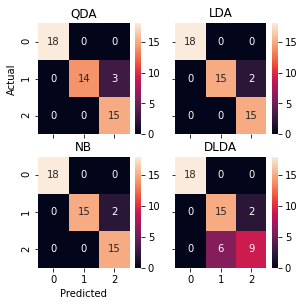

In [22]:
from mlwpy import *

qda  = discriminant_analysis.QuadraticDiscriminantAnalysis()
lda  = discriminant_analysis.LinearDiscriminantAnalysis()
nb   = naive_bayes.GaussianNB()
dlda = DLDA() # from mlwpy.py

da_methods = [qda, lda, nb, dlda]
names = ['QDA', 'LDA', 'NB', 'DLDA']

fig, axes = plt.subplots(2,2,figsize=(4.5, 4.5),
                         sharex=True, sharey = True)
for ax, model, name in zip(axes.flat, da_methods, names):
    preds = (model.fit(iris_train_ftrs, iris_train_tgt)
                  .predict(iris_test_ftrs))
    cm = metrics.confusion_matrix(iris_test_tgt, preds)
    sns.heatmap(cm, annot=True, cbar=True, ax=ax)
    ax.set_title(name)
    
axes[0,0].set_ylabel('Actual')
axes[1,0].set_xlabel('Predicted');

Be wary of reading too much into the differences here because they are not substantial.  There seems to be something to LDA as a sweet spot of the assumptions--based on Occam's razor, we make the *fewest* assumptions and get the job done.  LDA performs the best and makes the fewest assumptions.  

There is some variation in the results when rerunning with multiple train-test split.  Therefore, LDA is not necessarily always going to be the best.  However, in the larger problem, it is worthwhile exploring in more detail.  Let's look at the borders the methods create.

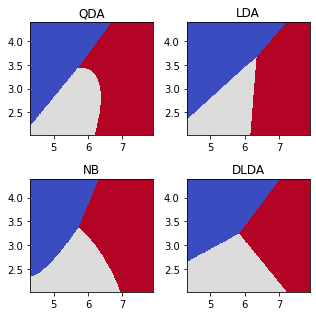

In [23]:
fig, axes = plt.subplots(2,2,figsize=(4.5, 4.5))
axes = axes.flat

for model, ax, name in zip(da_methods, axes, names):
    # plot boundary only uses the specified (two) dimensions to predict
    plot_boundary(ax, iris.data, iris.target, model, [0,1])
    ax.set_title(name)
plt.tight_layout()    

Both QDA and GNB have nonlinear boundaries, they curve a bit. LDA and DLDA both have linear borders between the classes.

# 8.6 Assumptions, Biases, and Classifiers

In two dimensions, such as a *xy*-graph, we can draw a line and break the plane of the graph into two havles.  This idea also applies in higher dimensions.  WE can split a 3D space with a 2D thing: a plane.  We can repeat the same process in higher and higher dimensions--even when we can't really draw or conceive of these things with our intuition. 

The line, the plane, and their higher-dimension cousins are all *linear forms* in a specific mathematical sense.  They are simple, straight ahead, without wiggles.  If we need wiggles, like curves, parabolas, or circle, these forms take us to the realm of *nonlinear* techniques.  Nearest neighbors and decision trees capture relationships that are more wiggly than linear forms allow. Most techniques, including linear regression, logistic regression, and SVCs, can be extended to deal with nonlinear data.  We do this by replacing the notion of similarity rooted in the covariance matrix with another called a *kernel*.  Kernels are discussed in detail in Section 13.2.

We moved from a very unbiased classifier--decision trees--through a variety of classifiers that make primarily linear borders (although GNB and QDA allow curved boundaries).  Here's how DTs and SVCs treat a simple example (is $y \gt x$):

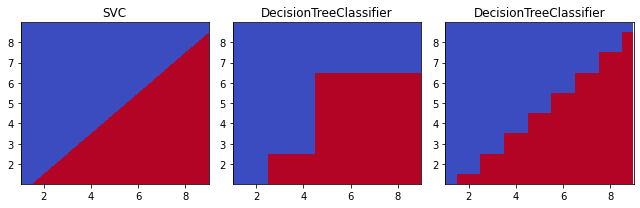

In [28]:
ftrs = np.mgrid[1:10, 1:10].T.reshape(-1, 2)
tgt = ftrs[:,0] > ftrs[:,1]

fig, axes = plt.subplots(1,3,figsize=(9,3))
axes = axes.flat

svc = svm.SVC(kernel='linear')
dt_shallow = tree.DecisionTreeClassifier(max_depth=3)
dt_deep = tree.DecisionTreeClassifier()
models = [svc, dt_shallow, dt_deep]

for model, ax in zip(models, axes):
    # plot boundary only uses the specified (two) dimensions to predict
    plot_boundary(ax, ftrs, tgt, model, [0,1])
    ax.set_title(get_model_name(model))
plt.tight_layout()    

The first decision tree is hampered by the fact that we only allowed it to make a few splits in the middle pane.  As we let it ask more and more questions, `max_depth` gets larger.  Unlike logistic regression and the various discriminant analysis methods, SVCs don't have any underlying notion of probability built into them, making them *different* from DAs.  If data happens to fall into the feature-wise independence assumption (i.e., the diagonal covariance matrix of GNB), then GNB is going to be the best model.

However, we never *know* ahead of time what assumptions will hold.  We apply a modeling method, like GNB, that comes with assumptions.  The better the assumptions line up with reality (i.e., the data), the better the method will do on that problem.  If the assumptions are met, we'd prefer GNB and we'd probably see it perform better classification.  If the assumptions are not met by reality, we can fall back to SVC.  From a certain perspective, SVCs make the fewest assumptions of the three models (the DA methods, logistic regression, and SVCs), so they are the most flexible.  Still, the other methods may do better when the assumptions are met.

As we move from SVCs to logistic regression to DA, we move from 

1. minimal assumptions about the data to 
2. a primitive data model taht relates features and targets to
3. varying degrees of assumptions about how the features are distributed, their relationships to the target, and the base rates of the targets.

Logistic regression attempts to capture the relationship between the inputs and the output.  It captures the probability of the output given what we know about the inputs.  However, it ignores any self-contained information from the target class.  For example, it ignores knowledge from the data that a particular disease is very rare.  

In contrast, the discriminant analysis methods model both a relationship between inputs and outputs *and* the base probabilities of the outputs.  Particularly, they capture:

1. The probability of the inputs given what we know about an output *and*
2. stand-alone information about the output

The notes at the EOC explain this in more depth.


# Comparison of Classifiers: Take Three

With significant new tools in our classificaiton toolbox, let's attack a problem a bit more difficult than the irises.

## 8.7.1 Digits

We'll make use of the *digits* dataset in `sklearn`.

In [29]:
digits = datasets.load_digits()

The data represents simple images of handwritten digits.  For example, the first digit is:

Shape: (8, 8)


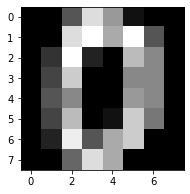

In [31]:
print('Shape:', digits.images[0].shape)
plt.figure(figsize=(3,3))
plt.imshow(digits.images[0], cmap='gray')

And it has a target value of:

In [32]:
digits.target[0]

0

The dataset comes in two forms. One (`digits.images`) is appropriate for display purposes; We used it above.  The other (`digits.data`) is appropriate for use in learning.  That form is a flattened row of the informatoin in the square $64 \times 64$ images.

Now we can build our learning problem.

In [35]:
classifier_parade = \
    {'LogReg(1)' : linear_model.LogisticRegression(max_iter=1000),
     'LogReg(2)' : linear_model.SGDClassifier(loss='log',
                                              max_iter=1000),
     'QDA' : discriminant_analysis.QuadraticDiscriminantAnalysis(),
     'LDA' : discriminant_analysis.LinearDiscriminantAnalysis(),
     'GNB' : naive_bayes.GaussianNB(),
     
     'SVC(1)' : svm.SVC(kernel='linear'),
     'SVC(2)' : svm.LinearSVC(),
     
     'DTC' : tree.DecisionTreeClassifier(),
     '5NN-C': neighbors.KNeighborsClassifier(),
     '10NN-C' : neighbors.KNeighborsClassifier(n_neighbors=10)}    
    
    
baseline = dummy.DummyClassifier(strategy='uniform')

base_score = skms.cross_val_score(baseline,
                                  digits.data, digits.target==1,
                                  cv=10,
                                  scoring='average_precision',
                                  n_jobs=-1)

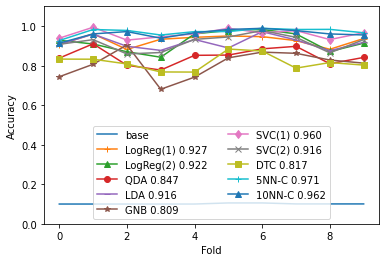

In [36]:
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(base_score, label='base')
for name, model in classifier_parade.items():
    cv_scores = skms.cross_val_score(model,
                                     digits.data, digits.target,
                                     cv=10,
                                     scoring='f1_macro',
                                     n_jobs=-1) # all CPUs
    my_lbl = '{} {:.3f}'.format(name, cv_scores.mean())
    ax.plot(cv_scores, label=my_lbl, marker=next(markers))
ax.set_ylim(0.0, 1.1)
ax.set_xlabel('Fold')
ax.set_ylabel('Accuracy')
ax.legend(loc='lower center', ncol=2);

Frankly, there is too much going on here to easily summarize.  There are some overall trends.  You can see that a classical method, Logistic Regression, is competing nicely with a very modern method, SVCs.  Our drop-dead simple Nearest Neighbors methods are doing even better. It would b egood practice to dive into comparing different classifiers on different metrics for this problem.  You might also be interested in comparing resource utilization of the different methods on *digits*.